In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import anderson

from copy import deepcopy
from statsmodels.stats.diagnostic import normal_ad

In [2]:
# Import the pickled raw dataframe
pdf = pd.read_pickle('../data/raw_data/raw_helm_data.pkl')

# Get the protein names
proteins = pdf['protein'].unique()

# Drop non excitatory spines
pdf = pdf[pdf['Homer'] != 0]

# Get logarithm of the main quantities
pdf.loc[:, ('DoI', 'Homer', 'poi', 'poiHR')] = pdf.loc[:, ('DoI', 'Homer', 'poi', 'poiHR')].map(lambda x: np.log(x))


/tmp/ipykernel_526316/1260736346.py:11: RuntimeWarning: divide by zero encountered in log
  pdf.loc[:, ('DoI', 'Homer', 'poi', 'poiHR')] = pdf.loc[:, ('DoI', 'Homer', 'poi', 'poiHR')].map(lambda x: np.log(x))


In [3]:
def custom_anderson(data):
    test = anderson(data)

    gen_crit_vals = np.insert(test.significance_level, 0, 100.)/100

    p_th = gen_crit_vals[(test.critical_values < test.statistic).sum()]

    return test.statistic, p_th



def fitplot_norm(ax, data, pval):
    
    if pval < 0.05:
        ax.hist(data, bins=15, color='gray', density=True)

    else:
        res = stats.norm.fit(data)
        _, bins, _ = ax.hist(data, bins=15, color='gray', density=True)
        ax.plot(bins, stats.norm.pdf(bins, *res), color='tab:blue', linewidth=2)


    

Filtering for log-normality of synaptic sizes (Chauvenet's criterion)

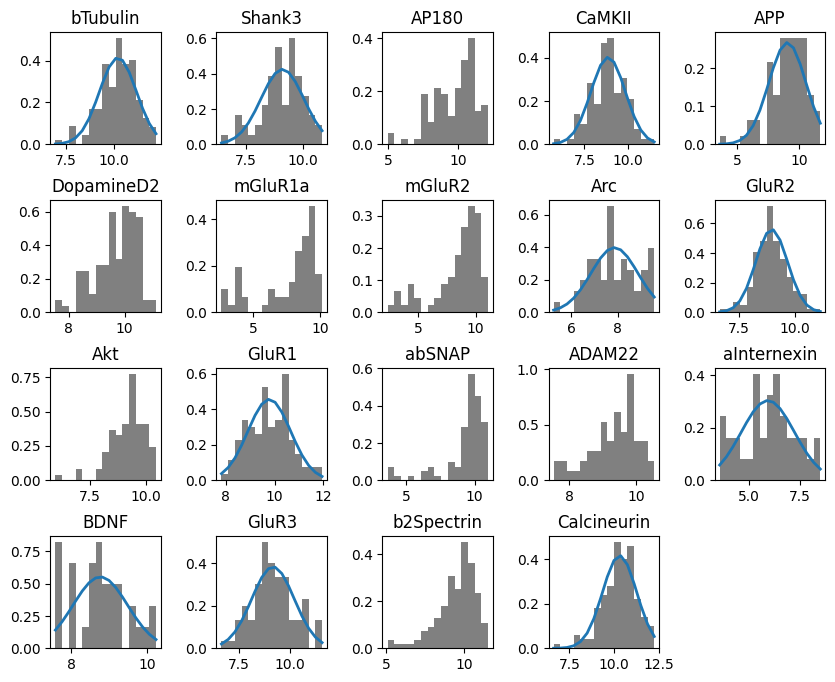

In [16]:
rows = int(len(proteins) // 5) + 1
fig = plt.figure(figsize=(10,rows*2), dpi=100)

good_pdf = {
    'protein' : [],
    'DoI' : [],
    'Homer' : [],
    'poi' : [],
}

bad_pdf = deepcopy(good_pdf)

for i, p in enumerate(proteins):
    dff = pdf[pdf['protein']==p]
    
    z_hom = stats.zscore(dff['Homer'])
    z_poi = stats.zscore(dff['poi'])

    filtered_hom = dff['Homer'].to_numpy()[np.where(z_hom > -3)]
    filtered_dio = dff['DoI'].to_numpy()[np.where(z_hom > -3)]
    filtered_conf = dff['poi'].to_numpy()[np.where(z_hom > -3)]

    _, pval_dio = custom_anderson(filtered_dio)
    _, pval_conf = custom_anderson(filtered_conf)
        
    ax = fig.add_subplot(rows, 5, i+1)

    fitplot_norm(ax,filtered_conf, pval_conf)

    ax.set_title(p)

    if pval_dio >= 0.05:
        good_pdf['protein'] += [p] * len(filtered_hom)
        good_pdf['DoI'] += filtered_dio.tolist()
        good_pdf['Homer'] += filtered_hom.tolist()
        good_pdf['poi'] += filtered_conf.tolist()

    else:
        bad_pdf['protein'] += [p] * len(filtered_hom)
        bad_pdf['DoI'] += filtered_dio.tolist()
        bad_pdf['Homer'] += filtered_hom.tolist()
        bad_pdf['poi'] += filtered_conf.tolist()

good_pdf = pd.DataFrame.from_dict(good_pdf)
bad_pdf = pd.DataFrame.from_dict(bad_pdf)

fig.subplots_adjust(hspace=0.5, wspace=0.5)

Proteins with log-normal spine sizes

In [18]:
for gp in good_proteins:
    print(gp)

bTubulin
Shank3
CaMKII
APP
Arc
GluR2
GluR1
aInternexin
BDNF
GluR3
Calcineurin


QQ plot for protein distributions

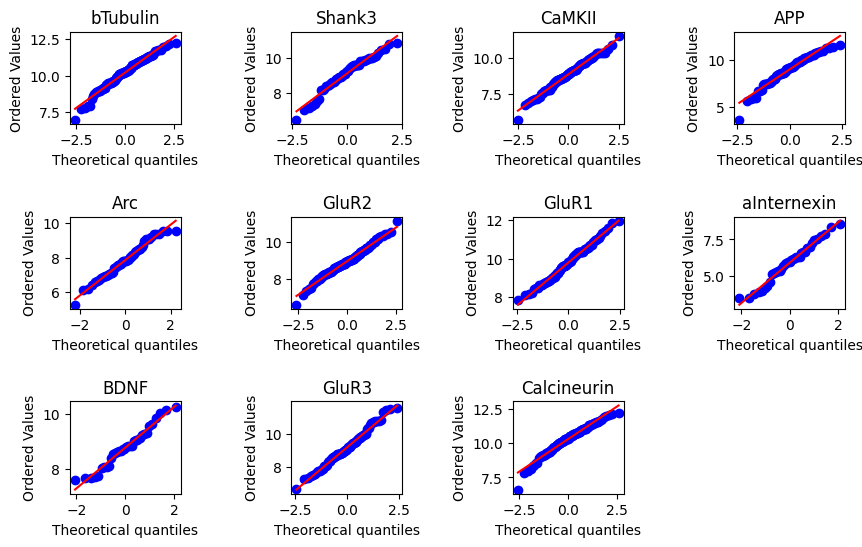

In [7]:
good_proteins = good_pdf['protein'].unique().tolist()
rows = int(len(good_proteins) // 4) + 1
fig = plt.figure(figsize=(10,rows*2), dpi=100)


for i, p in enumerate(good_proteins):
    dff = good_pdf[good_pdf['protein'] == p]

    ax = fig.add_subplot(rows, 4, i+1)
    stats.probplot(dff['poi'], dist='norm', plot=ax)

    ax.set_title(f'{p}')
    # r = dff.corr()

fig.subplots_adjust(hspace=1, wspace=1)

Correlations between proteins and Homer1 (datasets with log-normal sizes)

bTubulin             mean = 10.22 	std = 0.97
Shank3               mean = 9.11 	std = 0.95
CaMKII               mean = 8.86 	std = 0.99
APP                  mean = 9.04 	std = 1.50
Arc                  mean = 7.86 	std = 1.01
GluR2                mean = 8.94 	std = 0.71
GluR1                mean = 9.78 	std = 0.88
aInternexin          mean = 5.92 	std = 1.33
BDNF                 mean = 8.77 	std = 0.73
GluR3                mean = 9.16 	std = 1.05
Calcineurin          mean = 10.32 	std = 0.96


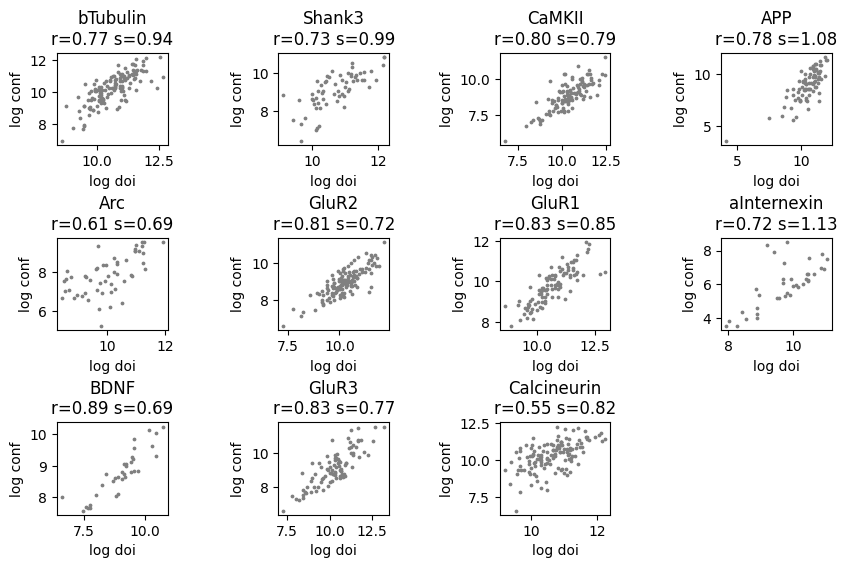

In [5]:
def fitplot_pearson(ax, X,Y):
    s, i, r, p, _ = stats.linregress(X,Y)

    ax.scatter(X,Y, s=3, c='gray')

    if p < 0.05:
        pass
        # ax.plot(X, i + s*X)
        # print(p)

    return r, s



good_proteins = good_pdf['protein'].unique().tolist()
rows = int(len(good_proteins) // 4) + 1
fig = plt.figure(figsize=(10,rows*2), dpi=100)


for i, p in enumerate(good_proteins):
    dff = good_pdf[good_pdf['protein'] == p]

    ax = fig.add_subplot(rows, 4, i+1)
    r,s = fitplot_pearson(ax, dff['DoI'], dff['poi'])

    print(f'{p:20}', f'mean = {dff['poi'].mean():.2f}', f'\tstd = {dff['poi'].std():.2f}')

    ax.set_title(f'{p}\nr={r:.2f} s={s:.2f}')
    ax.set_xlabel('log doi')
    ax.set_ylabel('log conf')
    # r = dff.corr()

fig.subplots_adjust(hspace=1, wspace=1)

In [19]:
# Save the proteins for the figure on log-normality of proteins
# good_pdf.to_csv('../data/validation_data/helm_data/lognom_proteins.csv')

Checking for existence of non-lognormal distributions

Text(0.5, 1.03, 'Log-normal incompatible proteins')

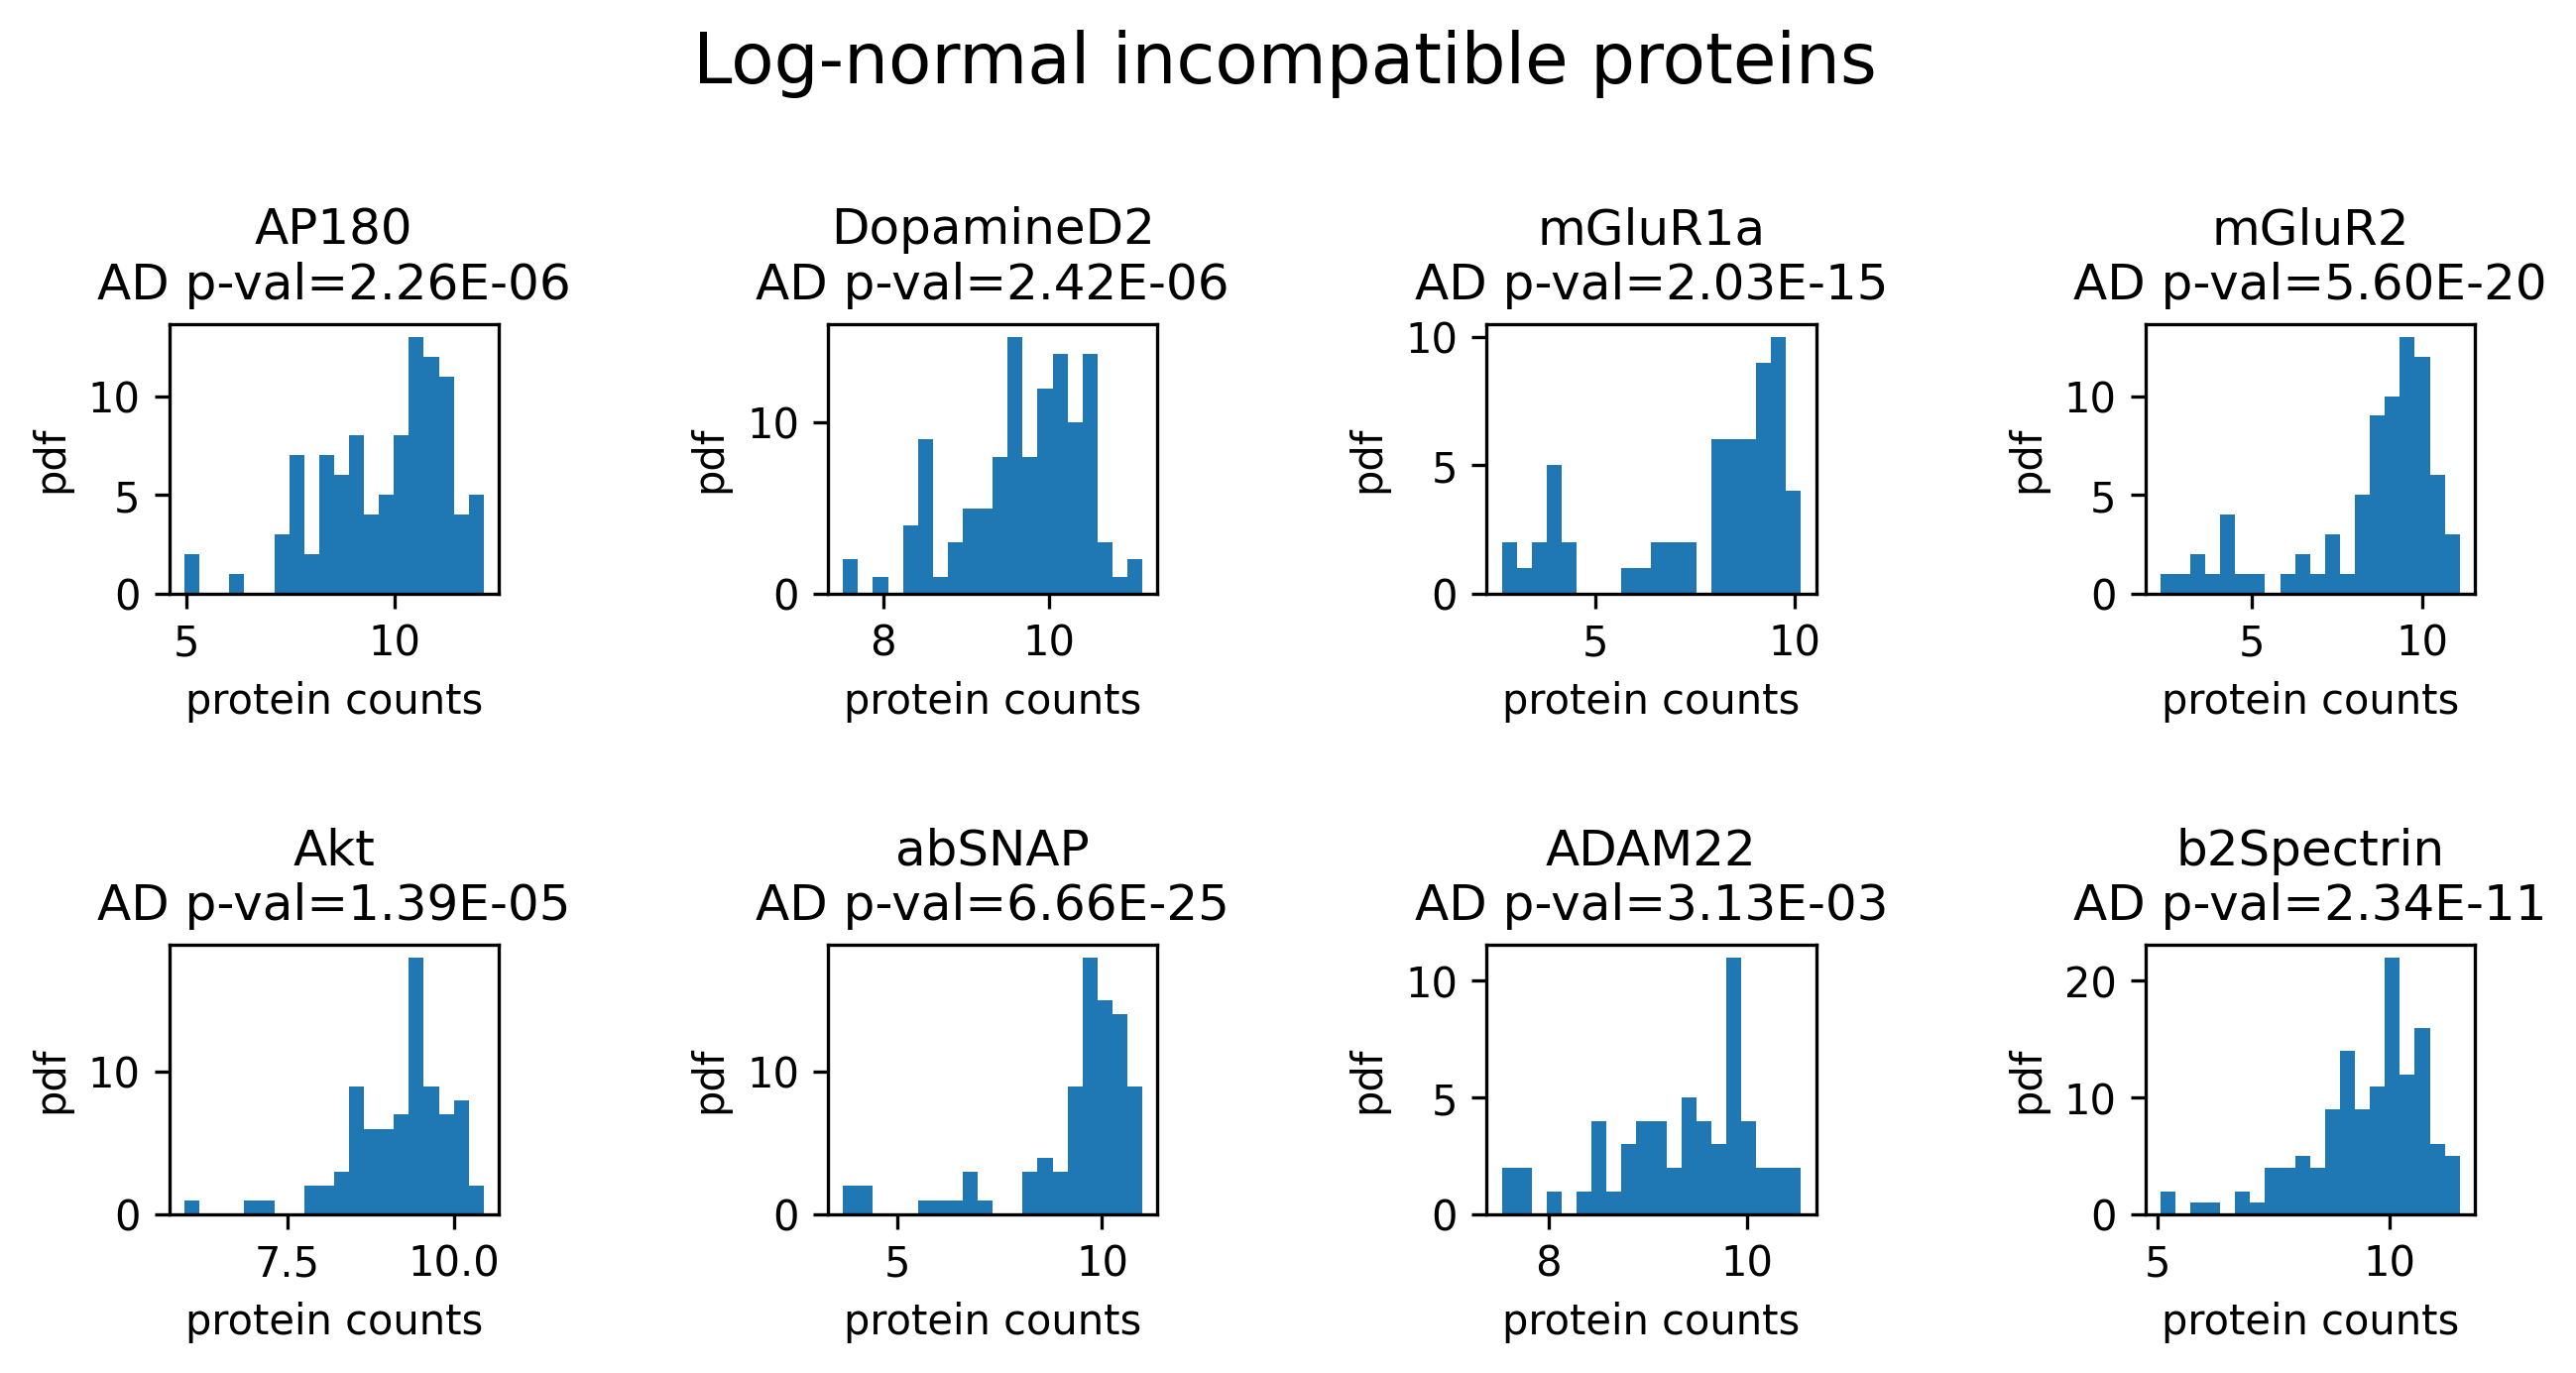

In [9]:
bad_proteins = bad_pdf['protein'].unique().tolist()
rows = int(len(bad_proteins) // 4) + 1

fig = plt.figure(figsize=(10,rows*2.2), dpi=300)

for i, p in enumerate(bad_proteins):
    dff = bad_pdf[bad_pdf['protein'] == p]

    X = dff['poi'].to_numpy()
    _, pval = normal_ad(np.log(X))

    ax = fig.add_subplot(rows, 4, i+1)
    # stats.probplot(dff['poi'], dist='norm', plot=ax)
    ax.hist(X, bins=20)

    ax.set_title(f'{p}\nAD p-val={pval:.2E}')
    ax.set_xlabel('protein counts')
    ax.set_ylabel('pdf')
    # r = dff.corr()

fig.subplots_adjust(hspace=1.3, wspace=1)
fig.suptitle('Log-normal incompatible proteins', y=1.03, fontsize=17)